In [27]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import pulp

In [28]:
def get_fpl_data():
    base_url = "https://fantasy.premierleague.com/api/bootstrap-static/"
    response = requests.get(base_url)
    data = response.json()
    return data

In [ ]:
fpl_data = get_fpl_data()

In [30]:
fpl_data.keys()

dict_keys(['chips', 'events', 'game_settings', 'game_config', 'phases', 'teams', 'total_players', 'element_stats', 'element_types', 'elements'])

In [31]:
teams_data = fpl_data['teams']
players_data = fpl_data['elements']
gameweek_data = fpl_data['events']
chips = fpl_data['chips']
game_config = fpl_data['game_config']

In [32]:
mapping = {1: "gk", 2: "def", 3: "mid", 4: "att"}  

In [44]:
gameweek_data

[{'id': 1,
  'name': 'Gameweek 1',
  'deadline_time': '2025-08-15T17:30:00Z',
  'release_time': None,
  'average_entry_score': 54,
  'finished': True,
  'data_checked': True,
  'highest_scoring_entry': 3772644,
  'deadline_time_epoch': 1755279000,
  'deadline_time_game_offset': 0,
  'highest_score': 127,
  'is_previous': False,
  'is_current': False,
  'is_next': False,
  'cup_leagues_created': False,
  'h2h_ko_matches_created': False,
  'can_enter': False,
  'can_manage': False,
  'released': True,
  'ranked_count': 9469118,
  'overrides': {'rules': {},
   'scoring': {},
   'element_types': [],
   'pick_multiplier': None},
  'chip_plays': [{'chip_name': 'bboost', 'num_played': 342779},
   {'chip_name': '3xc', 'num_played': 272642}],
  'most_selected': 235,
  'most_transferred_in': 1,
  'top_element': 531,
  'top_element_info': {'id': 531, 'points': 17},
  'transfers_made': 0,
  'most_captained': 381,
  'most_vice_captained': 235},
 {'id': 2,
  'name': 'Gameweek 2',
  'deadline_time': 

In [34]:
players_data_df = pd.DataFrame(players_data)

In [35]:
players_data_df = players_data_df[['now_cost','total_points', 'element_type', 'goals_scored', 'bps','assists', 'clean_sheets', 'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'influence', 'creativity', 'threat', 'ict_index', 'clearances_blocks_interceptions', 'recoveries', 'tackles', 'defensive_contribution', 'expected_goals', 'expected_assists', 'expected_goal_involvements', 'expected_goals_conceded', 'form', 'starts', 'minutes','web_name', 'team']]
players_data_df["element_type"] = players_data_df["element_type"].map(mapping)


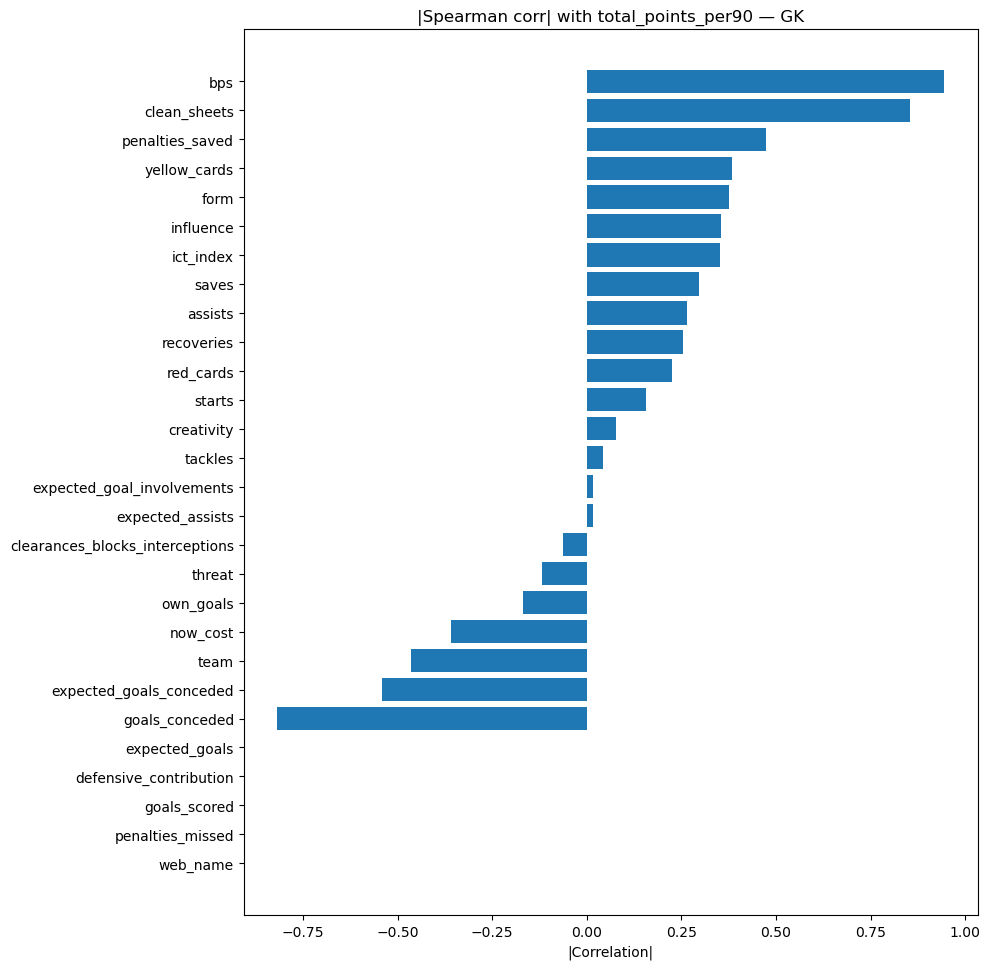

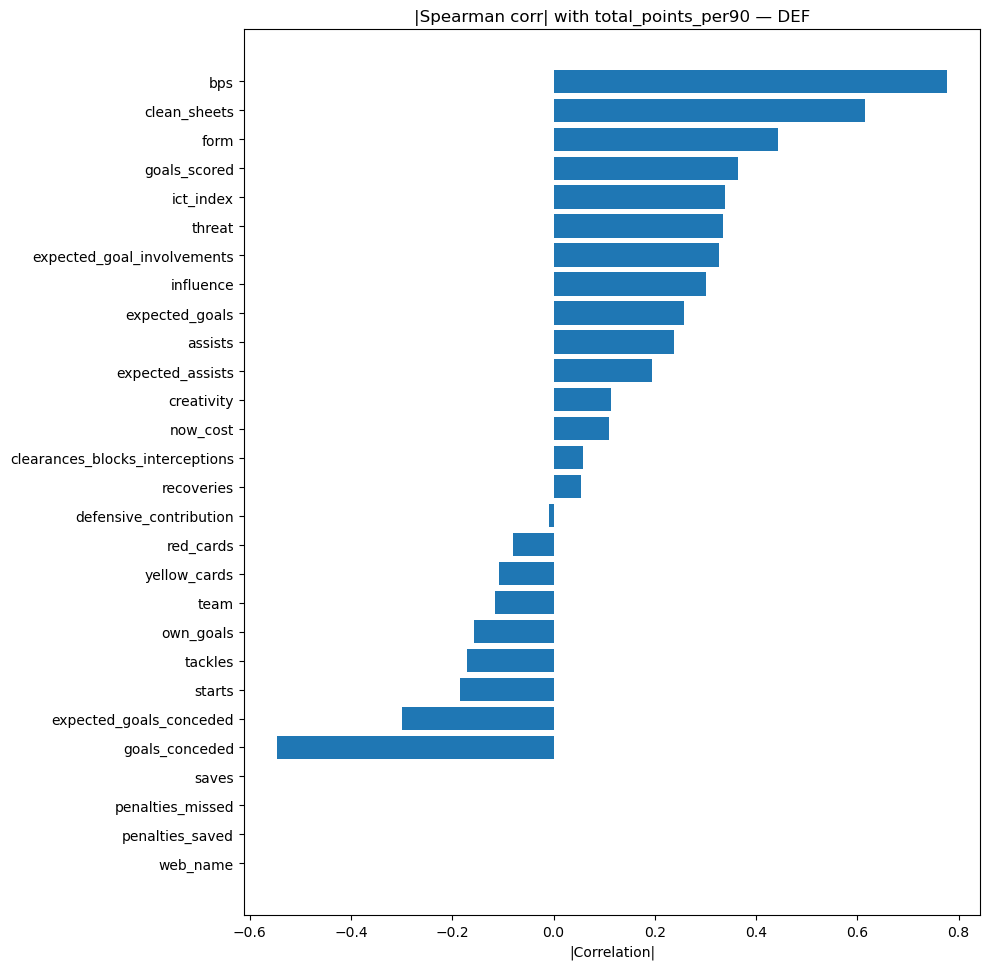

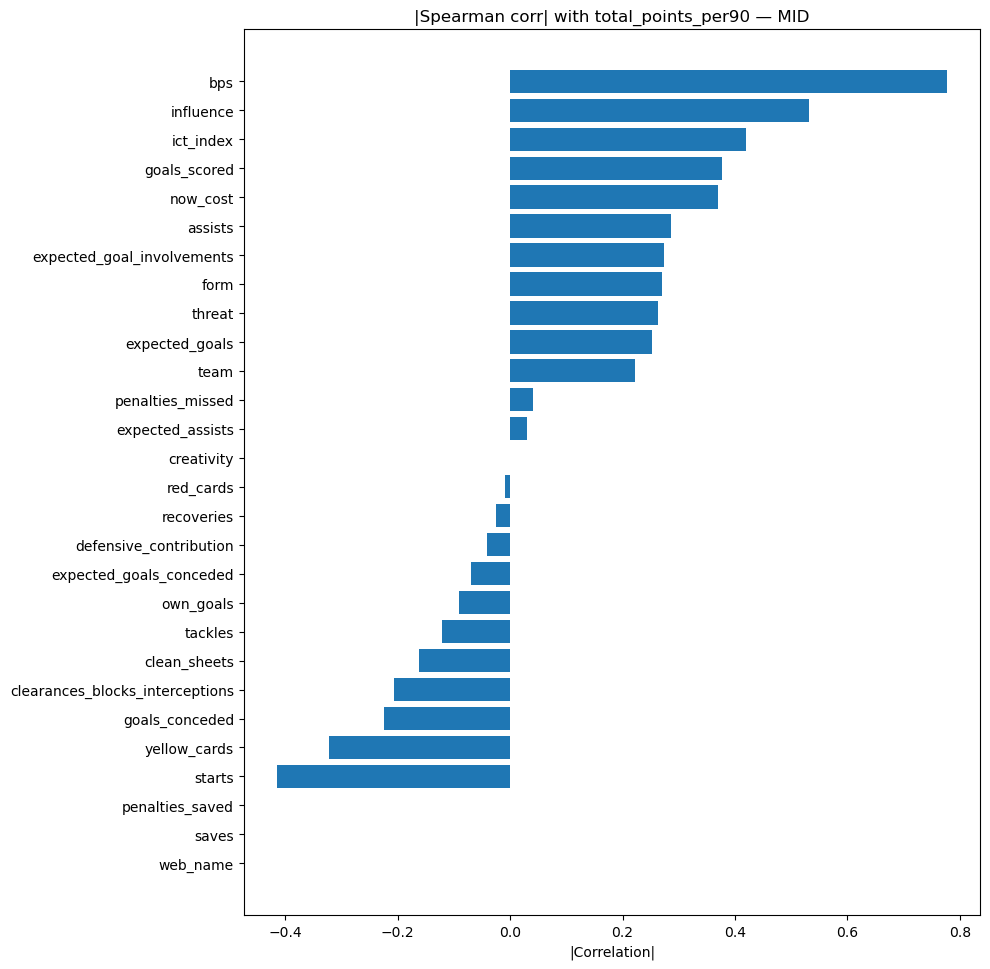

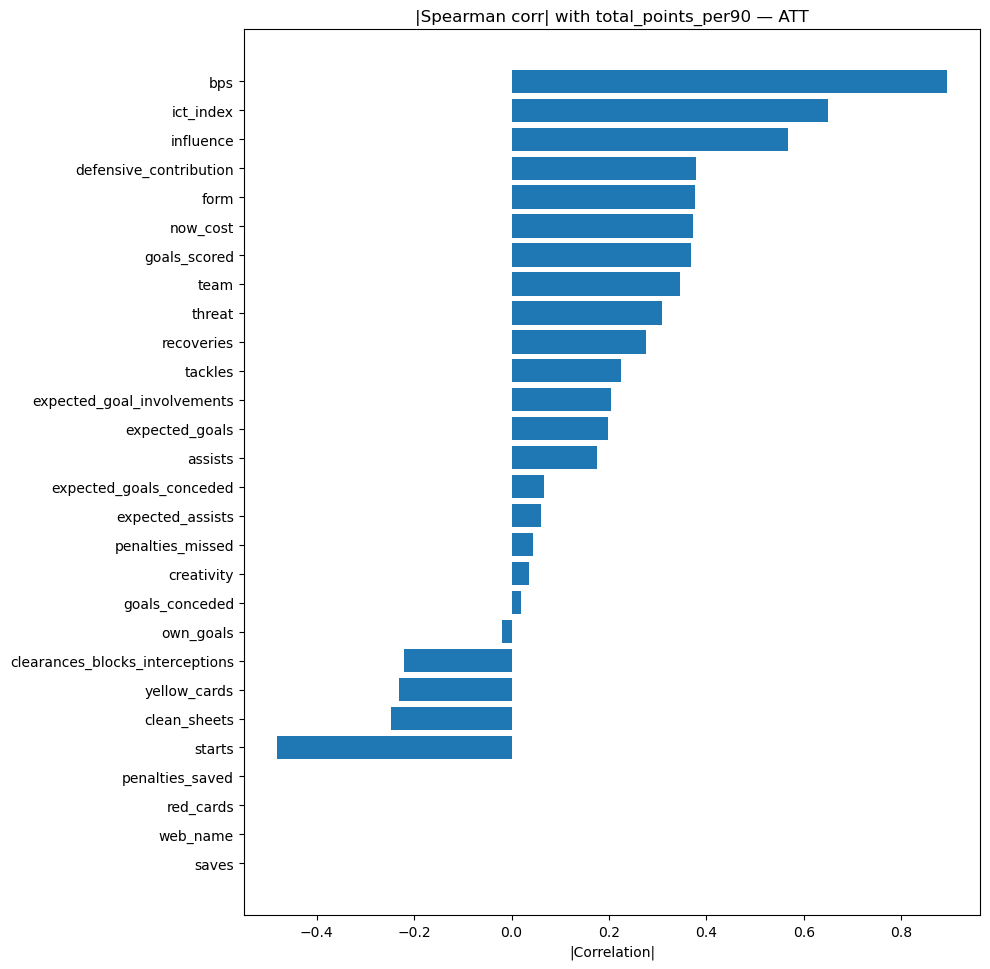

In [36]:
def corr_plots_by_position_per90_abs(
    df: pd.DataFrame,
    group_col: str = "element_type",
    target: str = "total_points",
    minutes_col: str = "minutes",
    positions=("gk", "def", "mid", "att"),
    method: str = "spearman",
):
    d = df.copy()

    for c in d.columns:
        if c != group_col:
            d[c] = pd.to_numeric(d[c], errors="coerce")

    num_cols = d.select_dtypes(include="number").columns
    if target not in num_cols or minutes_col not in num_cols:
        raise ValueError(f"'{target}' and '{minutes_col}' must be numeric columns in df.")

    denom = d[minutes_col].replace(0, np.nan) / 90.0
    per90 = d[num_cols].div(denom, axis=0)
    per90[minutes_col] = d[minutes_col]
    

    features = [c for c in num_cols if c not in (target, minutes_col)]
    corr_df = pd.DataFrame(index=list(positions), columns=features, dtype=float)

    for pos in positions:
        sub = per90.loc[d[group_col] == pos, [target] + features]
        if len(sub) < 2:
            continue

        s = sub.corr(method=method)[target].reindex(features)
    
        s_sorted = s.reindex(s.fillna(-1).sort_values(ascending=False).index).fillna(0)

        plt.figure(figsize=(10, max(4, 0.35 * len(s_sorted))))
        y = np.arange(len(s_sorted))
        plt.barh(y, s_sorted.values)
        plt.yticks(y, s_sorted.index)
        plt.gca().invert_yaxis()
        plt.title(f"|{method.title()} corr| with {target}_per90 — {pos.upper()}")
        plt.xlabel("|Correlation|")
        plt.tight_layout()
        plt.show()

        corr_df.loc[pos] = s

    return corr_df

corr_df = corr_plots_by_position_per90_abs(
    players_data_df,
    group_col="element_type",
    target="total_points",
    minutes_col="minutes",
    method="spearman",
)


In [37]:
feature_map = {
    'gk': ['now_cost','clean_sheets','penalties_saved','goals_conceded','saves','expected_goals_conceded'],
    'def': ['now_cost','clean_sheets','expected_goals_conceded','goals_conceded','assists','goals_scored','expected_goals','expected_assists','defensive_contribution'],
    'mid': ['now_cost','clean_sheets','goals_conceded','assists','goals_scored','expected_goals','expected_assists','defensive_contribution','creativity','threat','influence'],
    'att': ['now_cost','assists','goals_scored','expected_goals','expected_assists','creativity','threat','influence']
}

In [38]:
def fit_predict_by_position(df, feature_map, target="total_points", pos_col="element_type", pred_col="xgb_pred", params=None):
    d = df.copy()
    d[pos_col] = d[pos_col].astype("string")
    d[target] = pd.to_numeric(d[target], errors="coerce")
    d[pred_col] = np.nan

    base_params = dict(
        n_estimators=800,
        learning_rate=0.03,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="reg:squarederror",
        random_state=42
    )
    if params:
        base_params.update(params)

    models = {}
    for pos, feats in feature_map.items():
        missing = [c for c in feats + [target] if c not in d.columns]
        if missing:
            raise ValueError(f"{pos} missing columns: {missing}")

        sub = d.loc[d[pos_col].eq(pos), feats + [target]].copy()
        if len(sub) < 2:
            continue

        for c in feats:
            sub[c] = pd.to_numeric(sub[c], errors="coerce")

        sub = sub.dropna(subset=[target])
        if len(sub) < 2:
            continue

        X = sub[feats].fillna(0)
        y = sub[target].to_numpy()

        if len(sub) < 20:
            model = XGBRegressor(**base_params)
            model.fit(X, y, verbose=False)
        else:
            X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=42)
            model = XGBRegressor(**base_params)
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

        models[pos] = model
        d.loc[sub.index, pred_col] = model.predict(X)

    return d, models

In [39]:
players_with_preds_df, models = fit_predict_by_position(players_data_df, feature_map, target='total_points', pred_col='xgb_pred')

In [40]:
players_with_preds_df

,now_cost,total_points,element_type,goals_scored,bps,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,...,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,form,starts,minutes,web_name,team,xgb_pred
0,60,75,gk,0,303,0,9,10,0,0,...,0.00,0.04,0.04,10.12,3.3,17,1530,Raya,1,37.231339
1,41,0,gk,0,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.0,0,0,Arrizabalaga,1,-0.000381
2,40,0,gk,0,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.0,0,0,Hein,1,0.000187
3,39,0,gk,0,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.0,0,0,Setford,1,0.000187
4,62,81,def,1,279,2,7,5,0,0,...,0.82,0.69,1.51,6.17,0.0,11,990,Gabriel,1,81.083725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,45,22,def,1,71,1,0,26,1,0,...,1.61,1.04,2.65,18.36,0.7,12,1053,Krejčí,20,22.059729
766,54,21,att,1,64,0,0,13,0,0,...,0.61,0.06,0.67,5.45,1.8,3,335,Tolu,20,20.948416
767,45,9,att,0,37,1,0,4,0,0,...,0.03,0.27,0.30,3.05,1.3,0,91,Mané,20,8.994303
768,40,0,def,0,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.0,0,0,Olagunju,20,0.006045


In [41]:
solver = pulp.COIN_CMD(msg=False) 


In [42]:
def pick_starting_xi(
    df,
    points_col="xgb_pred",
    cost_col="now_cost",
    pos_col="element_type",
    team_col="team",
    budget=81.5,
    pos_limits={"gk": (1, 1), "def": (3, 5), "mid": (3, 5), "att": (1, 3)},
    max_from_team=3,
):
    d = df.copy()

    d[points_col] = pd.to_numeric(d[points_col], errors="coerce")
    d[cost_col] = pd.to_numeric(d[cost_col], errors="coerce")
    d = d.dropna(subset=[points_col, cost_col, pos_col, team_col]).reset_index(drop=True)

    cost_is_tenths = d[cost_col].max() > 25
    B = int(round(budget * 10)) if cost_is_tenths else float(budget)

    n = len(d)
    idx = range(n)

    prob = pulp.LpProblem("fpl_xi", pulp.LpMaximize)
    x = pulp.LpVariable.dicts("x", idx, cat="Binary")

    c = d[points_col].to_numpy()
    v = d[cost_col].to_numpy()

    prob += pulp.lpSum(c[i] * x[i] for i in idx)
    prob += pulp.lpSum(x[i] for i in idx) == 11
    prob += pulp.lpSum(v[i] * x[i] for i in idx) <= B

    for pos, (mn, mx) in pos_limits.items():
        mask = [i for i in idx if str(d.at[i, pos_col]) == pos]
        prob += pulp.lpSum(x[i] for i in mask) >= mn
        prob += pulp.lpSum(x[i] for i in mask) <= mx

    for t in d[team_col].unique():
        mask = [i for i in idx if d.at[i, team_col] == t]
        prob += pulp.lpSum(x[i] for i in mask) <= max_from_team

    prob.solve(solver)


    chosen_idx = [i for i in idx if pulp.value(x[i]) > 0.5]
    xi = d.loc[chosen_idx].copy()

    total_pred = float(xi[points_col].sum())
    total_cost = float(xi[cost_col].sum())
    total_cost_gbp = total_cost / 10 if cost_is_tenths else total_cost

    return xi, total_pred, total_cost_gbp

In [43]:
xi, xi_pred_points, xi_cost = pick_starting_xi(players_with_preds_df, budget=81.5)
xi[["web_name","element_type","team","now_cost","xgb_pred"]].sort_values(["element_type","xgb_pred"], ascending=[True,False])


,web_name,element_type,team,now_cost,xgb_pred
485,Haaland,att,13,151,150.974197
252,Chalobah,def,7,55,93.948219
288,Guéhi,def,8,53,93.006134
284,Muñoz,def,8,59,88.968300
7,J.Timber,def,1,65,85.948540
285,Lacroix,def,8,52,81.920799
320,Pickford,gk,9,55,69.997253
511,B.Fernandes,mid,14,92,98.946289
471,Foden,mid,13,90,90.945946
553,Bruno G.,mid,15,70,84.980743
